<a href="https://colab.research.google.com/github/mgonzal1/nma_wombat_connectivy_project/blob/master/connectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
#@title imports and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import sklearn.metrics
import ipywidgets as widgets 
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


In [19]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [20]:
# SET DEFAULTS
trial_time = 2
session=12
n_sessions = len(alldat)

In [21]:
#@title General functions to get data
def filter_no_go_choice(data_set):
  """
  In order to reduce the complexity on the decode model(A3), we are removing the no-go trials 
  so we kept binary choice (left or right) that fits with a LogisticRegression model
   Args: 
      data_set: Subset of alldat

  Returns:
   new_data_set (dict): dat['spks']: neurons by trials.
                        dat['brain_area']: brain area for each neuron recorded.
                        dat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
                        dat['contrast_left']: contrast level for left stimulus.
                        dat['response']: which side the response was (-1,  1). Choices for the right stimulus are -1.
  """
  new_data_set =  {}
  index_trials = data_set['response'].nonzero()
  # Remove baseline(first 50 bins) and get FR per neuron
  new_data_set.update({"spks":(data_set["spks"][:,index_trials[0],50:].sum(axis=2)/trial_time).T})
  new_data_set.update({"brain_area":data_set["brain_area"]})
  new_data_set.update({"response": data_set["response"][index_trials]})
  new_data_set.update({"contrast_right": data_set["contrast_right"][index_trials]})
  new_data_set.update({"contrast_left": data_set["contrast_left"][index_trials]})
  return new_data_set

def get_spks_from_area(dat,brain_area):
  spks = dat["spks"].T
  n_neurons = spks.shape[0]
  index_neurons = np.zeros(n_neurons,dtype=bool)
  for neuron in range(n_neurons):
    index_neurons[neuron] = dat['brain_area'][neuron] in brain_area

  area_data = (spks[index_neurons,:].T)
  return area_data, index_neurons

def get_visual_ctx(data_set):
  visual_ctx = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]
  visual_data, _ = get_spks_from_area(data_set, visual_ctx)
  return visual_data

def get_motor_ctx(data_set):
  motor_ctx = ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"]
  motor_data, _ = get_spks_from_area(data_set, motor_ctx)
  return motor_data

def get_stimulus(data_set):
  """
   Args: 
      data_set: (map) Subset of alldat
      
   Returns:
      stims[nTrials x 3]  bias: constant with ones
                          stim_left: contrast level for the right stimulus.
                          stim_right: contrast level for left stimulus.
  """


  stims = data_set['contrast_left'], data_set['contrast_right']
  stims = np.array(stims).T
  n_trials = stims.shape[0]
  stims = np.column_stack((np.ones(n_trials),stims))
  return stims

def get_response(data_set):
  """
   Args: 
      data_set: Subset of alldat

   Returns:
        np.array: which side the response was (-1, 0, 1). Choices for the right stimulus are -1.
  """
  response =  np.array(data_set['response'])
  return response

def get_binary_response(data_set):
  """
   To simplify the model we ares going to use a binary response instead of the 3 possible values: left, no-action, right
   to true or false comparing the stimulus to the expected actions. 

   Args: 
      data_set: Subset of alldat

   Returns:
        binary (np.array boolean) : Returns True or False
  """
  vis_left, vis_right = [data_set["stims"][:,1], data_set["stims"][:,2]]
  response = get_response(data_set)
  binary_response = np.sign(response)==np.sign(vis_left-vis_right)
  return binary_response

def split_validation_set(data_set):
  """
  Get a subset of alldat for validation purposes. This should be ~5%-10% of all the data.


  Returns:
   train_set (dict): dat['spks']: neurons by trials.
                     dat['brain_area']: brain area for each neuron recorded.
                     dat['stims']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
                     dat['response']: which side the response was (-1,  1). Choices for the right stimulus are -1.
  """

  stims=get_stimulus(data_set)
  response = get_response(data_set)
  spk= data_set['spks']
  # # create training and testing vars
  stim_train, stim_test, spk_train, spk_test, response_train, response_test = train_test_split(stims, spk, response, test_size=0.1)
  train_set = {
      "spks": spk_train, 
      "stims": stim_train, 
      "response": response_train, 
      "brain_area":data_set['brain_area']
      }
  validation_set = {
      "spks": spk_test,
      "stims": stim_test, 
      "response": response_test, 
      "brain_area":data_set['brain_area']
      }
  return train_set, validation_set

# Draft of sigmoide calculation
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

In [22]:
# Get train and validation data
data_set = filter_no_go_choice(alldat[session])
data_set, val_set = split_validation_set(data_set)
#train_set (dict): dat['spks']: neurons by trials.
#                  dat['brain_area']: brain area for each neuron recorded.
#                  dat['stims']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
#                  dat['response']: which side the response was (-1,  1). Choices for the right stimulus are -1.

# MODEL 1:  Encodig from visual stimulus

Using Multiple Linear Regresion:


\begin{align}
y = \theta_0 + \theta_1 x_1 + \theta_1 x_2 + ... +\theta_d x_d + \epsilon
\end{align}

where $\theta_0$ is the intercept and $d$ is the number of features.


Testing with k-fold cross-validation 

**Metrics:**
*   Visual stimulus [nTrials x 3] : Contrast on left and right

\begin{align}
\mathbf{X} = 
\begin{bmatrix}
1 & x_{1,1} & x_{1,2}  \\
1 & x_{2,1} & x_{2,2} \\
\vdots & \vdots & \vdots \\
1 & x_{n,1} & x_{n,2}
\end{bmatrix}
\end{align}


*   Visual neurons matrix [nTrials x Neurons]:  neurons firing rate on visual area

\begin{align}
\mathbf{Y} = 
\begin{bmatrix}
y_{1,1} & y_{1,2} & \dots & y_{1,m}  \\
y_{2,1} & y_{2,2}  & \dots & y_{2,m} \\
\vdots & \vdots  & \dots & \vdots\\
y_{n,1} & y_{n,2} & \dots  &  y_{n,m}
\end{bmatrix}
\end{align}



**Returns**
*  A1 matrix [3x ntrials]

\begin{align}
\mathbf{A1} = 
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2}& \dots \ & \theta_{1,m}\\
\theta_{2,1} & \theta_{2,2}& \dots & \theta_{2,m}\\
\theta_{3,1} & \theta_{3,2}& \dots & \theta_{3,m}\\
\end{bmatrix}
\end{align}





In [23]:
# Get data
visual_dat = get_visual_ctx(data_set)
stim = data_set["stims"]

# Model Linear Regression
model = LinearRegression(fit_intercept=False).fit(stim, visual_dat) 

A1 = model.coef_.T
visual_dat_hat = model.predict(stim)
visual_dat_hat = stim @ A1

#MSE and R2
mse = np.mean( (visual_dat-visual_dat_hat)**2 )
r2_metrics =  sklearn.metrics.r2_score(visual_dat,visual_dat_hat)

print("R2: {}".format(r2_metrics))
print("MSE: {}".format(mse))


R2: 0.036372912829334886
MSE: 4.365238927380802


/usr/local/lib/python3.8/site-packages/IPython/core/inputtransformer2.py:484: UserWarning: `make_tokens_by_line` received a list of lines which do not have lineending markers ('\n', '\r', '\r\n', '\x0b', '\x0c'), behavior will be unspecified
  warnings.warn("`make_tokens_by_line` received a list of lines which do not have lineending markers ('\\n', '\\r', '\\r\\n', '\\x0b', '\\x0c'), behavior will be unspecified")


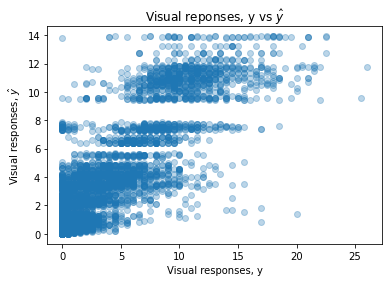

In [24]:
# plt.scatter(visual_dat.flatten(), visual_dat_hat.flatten()) 

plt.scatter(visual_dat,visual_dat_hat, alpha=0.3)
plt.title("Visual reponses, y vs $\hat y$ ")
plt.xlabel("Visual responses, y")
plt.ylabel("Visual responses, $\hat y$")
plt.show()

## Analize correlations per neuron

*   Calculate Root MSE 

 \begin{align}
 RMSE = \sqrt{\sum_{i=1}^N(y_i - \hat y_i)^2}\\
\end{align}

* RMSE normalized per Neuron

\begin{align}
nRMSE = \frac{RMSE}{\bar y}
\end{align}


*   Calculate $R^2$ per Neuron


\begin{align}
R^2 = \frac{\sum_{i=1}^n(\hat y_i - \ y)^2}{\sum_{i=1}^n (y_i - \ \bar{y})^2}
\end{align}



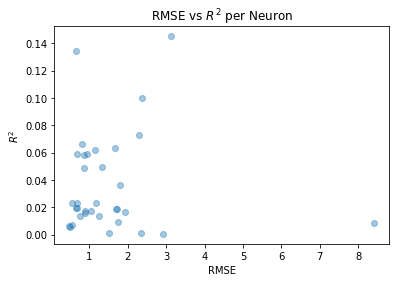

In [25]:
n_visual_dat = np.zeros(visual_dat.shape[1])
n_visual_dat_hat = np.zeros(visual_dat.shape[1])
n_mse = np.zeros(visual_dat.shape[1])
n_r2_metrics = np.zeros(visual_dat.shape[1])
n_mse_norm = np.zeros(visual_dat.shape[1])

for j in range(visual_dat.shape[1]):

  n_visual_dat =visual_dat[:,j]

  model_n = LinearRegression(fit_intercept=False).fit(stim, n_visual_dat)

  A1_n = model_n.coef_.T

  n_visual_dat_hat = stim @ A1_n
  n_visual_dat_mean= np.mean(n_visual_dat)
  
  n_mse [j]= np.mean( (n_visual_dat-n_visual_dat_hat)**2 )
  n_mse_norm [j]= n_mse [j]/ n_visual_dat_mean
  a=np.sum((n_visual_dat_hat-n_visual_dat)**2)
  b=np.sum((n_visual_dat-n_visual_dat_mean)**2)

  
  n_r2_metrics [j] = 1 - (a/b)

plt.scatter(n_mse_norm,n_r2_metrics,alpha=0.4)
plt.title("RMSE vs $R^2$ per Neuron")
plt.xlabel("RMSE")
plt.ylabel("$R^2$")
plt.show()

## Cross-validation: Testing with k-fold 

from Scikit-learn (https://scikit-learn.org/stable/modules/cross_validation.html)
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />



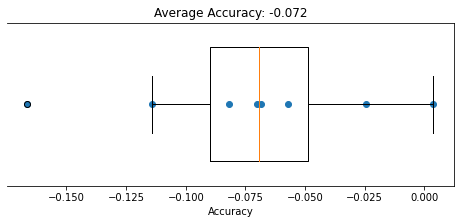

In [26]:
#@title Cross-validation, cv=8
num_splits =8
accuracies = (cross_val_score(model, stim, visual_dat, cv=8))

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(num_splits))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average Accuracy: {np.mean(accuracies):.3f}"
)
ax.spines["left"].set_visible(False)

# MODEL2: Connectivity Matrix ,  The black box

We try different models for our "black box" and we did some comparissons among them. 

*Spoiler alert, all were bad!*

For future work we need to understand better the correleation between this areas and probabaly make a better decision on the brain areas . 
 
##Models:
* Ridge
* Linear Regression
* Neural Network

**Metrics:**

* Visual data hat `[nTrials x nNeurons_visual]` :  predicted by the encoding model 1. Spikes rates of neurons involved in visual function.

\begin{align}
\mathbf{\hat Y} = 
\begin{bmatrix}
y_{1,1} & y_{1,2} & \dots & y_{1,m}  \\
y_{2,1} & y_{2,2}  & \dots & y_{2,m} \\
\vdots & \vdots  & \dots & \vdots\\
y_{n,1} & y_{n,2} & \dots  &  y_{n,m}
\end{bmatrix}
\end{align}

* Motor data hat `[nTrials x nNeurons_motor]`: predicted by the model 3. Spikes rates of neurons involved in motor function.

\begin{align}
\mathbf{\hat M} = 
\begin{bmatrix}
y_{1,1} & y_{1,2} & \dots & y_{1,m}  \\
y_{2,1} & y_{2,2}  & \dots & y_{2,m} \\
\vdots & \vdots  & \dots & \vdots\\
y_{n,1} & y_{n,2} & \dots  &  y_{n,m}
\end{bmatrix}
\end{align}

**Returns**:
* A2 `[nNeurons_visual , nNeurons_motor]`: Weight  matrix of connectivity model (visual area to motor area)


\begin{align}
\mathbf{A2} = 
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2}& \dots \ & \theta_{1,m}\\
\theta_{2,1} & \theta_{2,2}& \dots & \theta_{2,m}\\
\vdots & \vdots  & \dots & \vdots\\
\theta_{n,1} & \theta_{n,2}& \dots & \theta_{n,m}\\
\end{bmatrix}
\end{align}




### Model Ridge 
Regularization with ridge penalty (L2).

$$-\log\mathcal{L}'(\theta | X, y)=
-\log\mathcal{L}(\theta | X, y) +\frac\beta2\sum_i\theta_i^2,
$$



In [27]:
# obtains motor areas matrix and sets model
motor_dat = get_motor_ctx(data_set)
ridge = Ridge(alpha=1,fit_intercept=False)
# obtains weight matrix A2
ridge.fit(visual_dat_hat, motor_dat) 
A2 = ridge.coef_.T
# obtains prediction
motor_dat_hat = visual_dat_hat@A2

# MSE & R2
print("ridge MSE:", mean_squared_error(motor_dat, motor_dat_hat))
print("ridge score:",ridge.score(visual_dat_hat, motor_dat))


ridge MSE: 13.685059655242773
ridge score: 0.04107709282990732


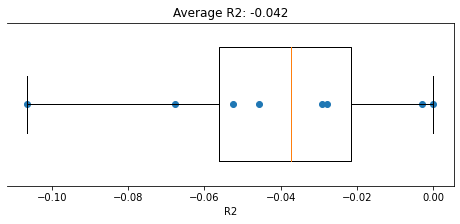

In [28]:
#@markdown Cross-validation, cv=8
num_splits =8
accuracies_ridge = (cross_val_score(ridge, visual_dat_hat, motor_dat, cv=8))

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies_ridge, vert=False, widths=.7)
ax.scatter(accuracies_ridge, np.ones(num_splits))
ax.set(
  xlabel="R2",
  yticks=[],
  title=f"Average R2: {np.mean(accuracies_ridge):.3f}"
)
ax.spines["left"].set_visible(False)

# MODEL 3:  Decoding from motor 
Obtaining predicted motor that will be used on Model2

Logistic Regression 



**Metrics:**
*   Motor matrix `[nTrials x nNeurons]`: spikes rates of neurons from areas related to motor function. 

\begin{align}
\mathbf{M} = 
\begin{bmatrix}
y_{1,1} & y_{1,2} & \dots & y_{1,m}  \\
y_{2,1} & y_{2,2}  & \dots & y_{2,m} \\
\vdots & \vdots  & \dots & \vdots\\
y_{n,1} & y_{n,2} & \dots  &  y_{n,m}
\end{bmatrix}
\end{align}


*   Choice `[nTrials]`: 2 categories.  Task of turning a wheel to the left or to the rigth. *(NoGo trials were ignored for simplicity)*

\begin{align}
\mathbf{Choice} = 
\begin{bmatrix}
x_{1,1} & x_{1,2} & \dots & x_{1,m}  \\
\end{bmatrix}
\end{align}



**Returns**
* A3 `[nNeurons]`: Weight vector

\begin{align}
\mathbf{A3} = 
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2}& \dots \ & \theta_{1,m}\\
\end{bmatrix}
\end{align}

* Motor matrix hat `[nTrials x nNeurons]`: predicted spikes rates of neurons from areas related to motor function.

\begin{align}
\mathbf{\hat M} = 
\begin{bmatrix}
y_{1,1} & y_{1,2} & \dots & y_{1,m}  \\
y_{2,1} & y_{2,2}  & \dots & y_{2,m} \\
\vdots & \vdots  & \dots & \vdots\\
y_{n,1} & y_{n,2} & \dots  &  y_{n,m}
\end{bmatrix}
\end{align}


In [29]:
# obtenemos matrices 'y' y 'x'
motor_dat = get_motor_ctx(data_set)
choice = data_set["response"]>0
#definimos el modelo & ajustamos los datos
model_A3 = LogisticRegression(fit_intercept=False,max_iter=5000).fit(motor_dat, choice)
A3 = model_A3.coef_.T
choice_hat = (sigmoid(motor_dat @ A3)>0.5).flatten()
#choice_hat = model_A3.predict(motor_dat)
acc = np.mean(choice==choice_hat)
print("ACC: {}".format(acc))
#print("MSE: {}".format(mse_A3))

ACC: 1.0


# Integrated Model
$$ \hat{choice} = sigmoid(stim A1 A2 A3) $$

**Metrics**
* stim `[nTrials x 3]` :  Visual stimulus, contrast on left and right

\begin{align}
\mathbf{X} = 
\begin{bmatrix}
1 & x_{1,1} & x_{1,2}  \\
1 & x_{2,1} & x_{2,2} \\
\vdots & \vdots & \vdots \\
1 & x_{n,1} & x_{n,2}
\end{bmatrix}
\end{align}


* A1 `[3 x nNeurons_visual]` : Weight matrix of encoding model (visual stimulus to visual area)

\begin{align}
\mathbf{A1} = 
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2}& \dots \ & \theta_{1,m}\\
\theta_{2,1} & \theta_{2,2}& \dots & \theta_{2,m}\\
\theta_{3,1} & \theta_{3,2}& \dots & \theta_{3,m}\\
\end{bmatrix}
\end{align}


* A2 `[nNeurons_visual , nNeurons_motor]`: Weight  matrix of connectivity model (visual area to motor area)

\begin{align}
\mathbf{A2} = 
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2}& \dots \ & \theta_{1,m}\\
\theta_{2,1} & \theta_{2,2}& \dots & \theta_{2,m}\\
\vdots & \vdots  & \dots & \vdots\\
\theta_{n,1} & \theta_{n,2}& \dots & \theta_{n,m}\\
\end{bmatrix}
\end{align}


* A3 `[nNeurons_motor]`: Weight vector of decoding model (motor area to task response)

\begin{align}
\mathbf{A3} = 
\begin{bmatrix}
\theta_{1,1} & \theta_{1,2}& \dots \ & \theta_{1,m}\\
\end{bmatrix}
\end{align}


In [30]:
choice_hat = (sigmoid(stim @ A1 @ A2 @ A3)>0.5).flatten()
acc = np.mean(choice==choice_hat)
print("ACC: {}".format(acc))

ACC: 0.8584474885844748


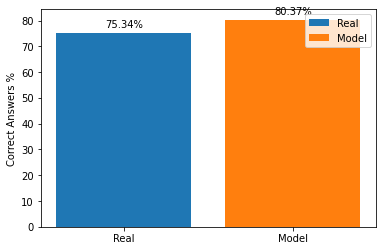

In [31]:
#@title Behavior Accuracy 
data_hat_set =  {
      "stims": stim, 
      "response": choice_hat*2 -1 
      }

binary_resp_behav=get_binary_response(data_set)
acc_behav= 100*(np.sum(binary_resp_behav==True)/len(binary_resp_behav))

binary_resp_model=get_binary_response(data_hat_set)
acc_behav_model= 100*(np.sum(binary_resp_model==True)/len(binary_resp_model))


labels = ["Behavior", "Model"]
#x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar( "Real", acc_behav,  label='Real')

rects2 = ax.bar("Model" , acc_behav_model,  label='Model')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correct Answers %')


ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()

# Perturbations

*  A1, A2 or A3 matrixes were randomly perturbated, setting  to 0.

Example, 50% of perturbation 

\begin{align}
\mathbf{Ax} = 
\begin{bmatrix}
0_{1,1} & \theta_{1,2}& \ 0_{1,3}& 0_{1,4}\\
\theta_{2,1} & 0_{2,2} & \ 0_{2,3}& \theta_{2,4}\\
0_{3,1} & \theta_{3,2} & \theta_{3,3}& \theta_{3,4}\\
\end{bmatrix}
\end{align}


In [32]:
def simulate_pertubations(weight_matrix, pct_lesion):
  n_rows,n_cols = weight_matrix.shape
  X = np.array(weight_matrix) # make a deep copy
  X[np.random.rand(n_rows,n_cols)<pct_lesion]=0
  return X

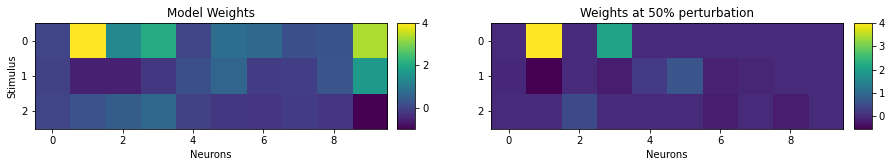

In [33]:
#@markdown Example of the perturbations on our weigth matrixes
from mpl_toolkits.axes_grid1 import make_axes_locatable
X= A1
X_perturbed = simulate_pertubations(A1, .5)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
im0 = axs[0].imshow(X[:, :10])
im1 = axs[1].imshow(X_perturbed[:, :10])

divider = make_axes_locatable(axs[0])
cax0 = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im0, cax=cax0)
divider = make_axes_locatable(axs[1])
cax1 = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im1, cax=cax1)
axs[0].set_ylabel("Stimulus")
axs[1].set_xlabel("Neurons")
axs[0].set_xlabel("Neurons");
axs[0].set_title("Model Weights", )
axs[1].set_title("Weights at 50% perturbation");

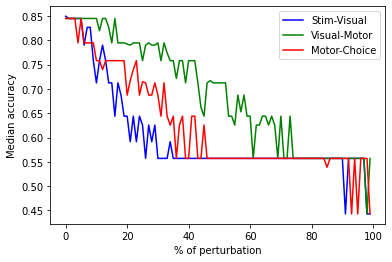

In [34]:
pct_lesions = np.linspace(.05, .99, 100)

n_sims = 100
acc_m = np.zeros((len(pct_lesions), 3))

for index,  pct_lesion in enumerate(pct_lesions):
  acc = np.zeros((3,100))
  for sim in range(n_sims):
    p_A1= simulate_pertubations(A1, pct_lesion) # p_A1 matrix of 0's
    p_A2= simulate_pertubations(A2, pct_lesion)
    p_A3= simulate_pertubations(A3, pct_lesion)
    p_choice = (sigmoid(stim @ p_A1 @ A2 @ A3)>0.5).flatten()
    acc[0,sim] = np.mean(choice==p_choice)
    p2_choice = (sigmoid(stim @ A1 @ p_A2 @ A3)>0.5).flatten()
    acc[1,sim] = np.mean(choice==p2_choice)
    p3_choice = (sigmoid(stim @ A1 @ A2 @ p_A3)>0.5).flatten()
    acc[2,sim] = np.mean(choice==p3_choice)
  
  acc_m[index] = np.median(acc,axis=1)

acc_m = acc_m.T
plt.plot(acc_m[0], label="Stim-Visual", color='blue', ) # A1
plt.plot(acc_m[1], label="Visual-Motor", color='green') 
plt.plot(acc_m[2], label="Motor-Choice", color='red')
plt.legend()

plt.xlabel('% of perturbation')
plt.ylabel('Median accuracy')
plt.show()